In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import copy
import folium

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
#Amsterdam
amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

#Athens
athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

#Barcelona
barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

#Berlin
berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

#Budapest
budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

#Lisbon
lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

#London
london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

#Paris
paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

#Rome
rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

#Vienna
vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
datasets = [
    (amsterdam_weekdays, "Amsterdam", True),
    (amsterdam_weekend, "Amsterdam", False),
    (athens_weekdays, "Athens", True),
    (athens_weekend, "Athens", False),
    (barcelona_weekdays, "Barcelona", True),
    (barcelona_weekend, "Barcelona", False),
    (berlin_weekdays, "Berlin", True),
    (berlin_weekend, "Berlin", False),
    (budapest_weekdays, "Budapest", True),
    (budapest_weekend, "Budapest", False),
    (lisbon_weekdays, "Lisbon", True),
    (lisbon_weekend, "Lisbon", False),
    (london_weekdays, "London", True),
    (london_weekend, "London", False),
    (paris_weekdays, "Paris", True),
    (paris_weekend, "Paris", False),
    (rome_weekdays, "Rome", True),
    (rome_weekend, "Rome", False),
    (vienna_weekdays, "Vienna", True),
    (vienna_weekend, "Vienna", False)
]

df = pd.DataFrame()

for data, city, is_weekday in datasets:
    data['city'] = city
    data['weekday'] = is_weekday
    df = pd.concat([df, data], ignore_index=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

print(df.head())
print(df.shape)

      realSum     room_type  room_shared  room_private  person_capacity  \
0  194.033698  Private room        False          True              2.0   
1  344.245776  Private room        False          True              4.0   
2  264.101422  Private room        False          True              2.0   
3  433.529398  Private room        False          True              4.0   
4  485.552926  Private room        False          True              2.0   

   host_is_superhost  multi  biz  cleanliness_rating  \
0              False      1    0                10.0   
1              False      0    0                 8.0   
2              False      0    1                 9.0   
3              False      0    1                 9.0   
4               True      0    0                10.0   

   guest_satisfaction_overall  ...      dist  metro_dist  attr_index  \
0                        93.0  ...  5.022964    2.539380   78.690379   
1                        85.0  ...  0.488389    0.239404  631.176378

In [4]:
# path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
# df = pd.read_csv(path, index_col=0)
# df.head()

# Data Exploration Process

## Pre-Processing

### Add data shuffle

In [5]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

### DEALING WITH MISSING VALUES

In [6]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


In [7]:
df.shape

(51707, 21)

In [8]:
df = df.dropna()
df.shape

(51707, 21)

### Remove OUTLIERS

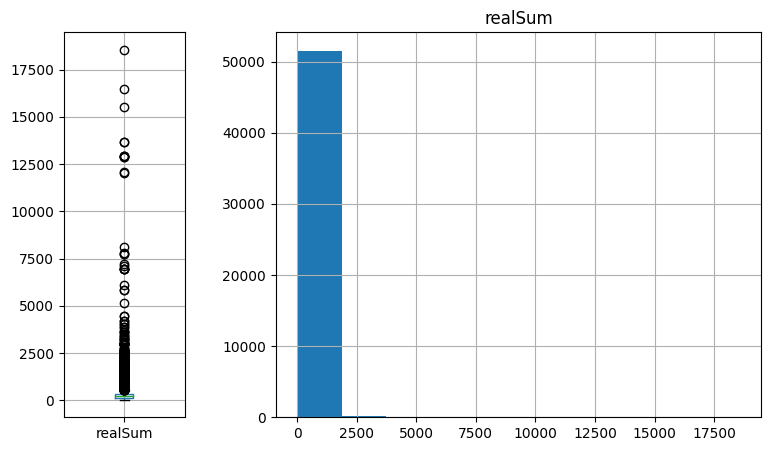

In [9]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [10]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

In [11]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 3662)

In [12]:
df['realSum'][small_outliers | big_outliers].head()

60     698.806972
66     956.983937
83     593.852160
95     636.702364
99    2311.738714
Name: realSum, dtype: float64

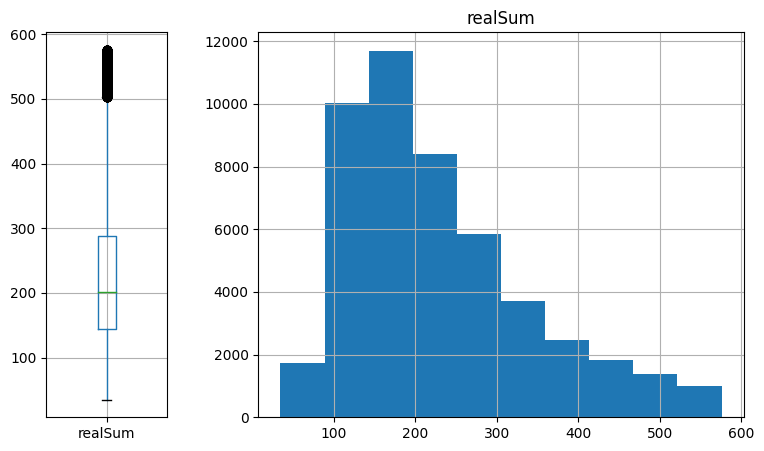

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [14]:
df = df[~(small_outliers | big_outliers)]
df.shape

(48045, 21)

In [15]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

## Data Clustering

In [16]:
df_copy = df.copy()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

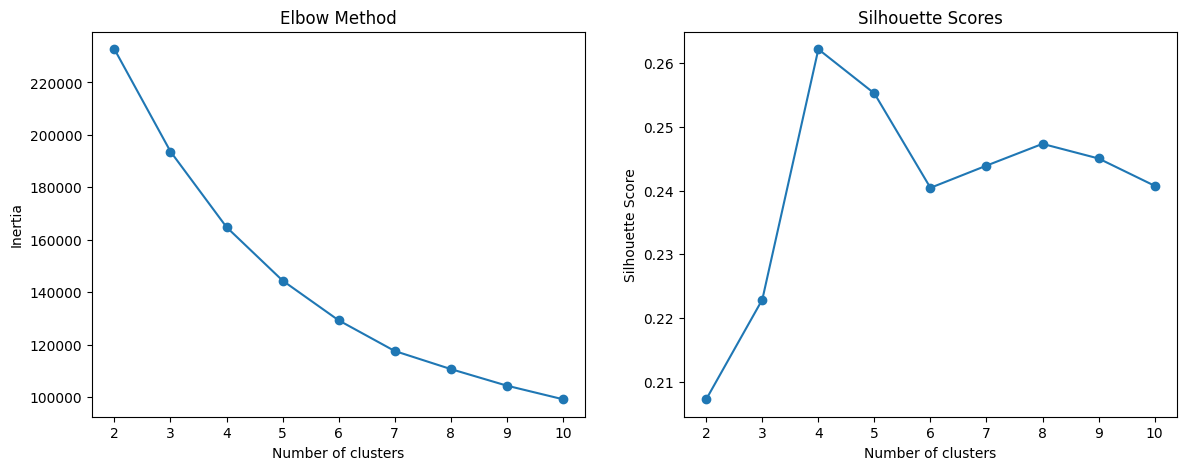

In [17]:
# Selecting the relevant features
features = df_copy[['realSum', 'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'lng', 'lat']]

# Handling missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Determining the optimal number of clusters using the Elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)  # Testing from 2 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plotting the Elbow curve and Silhouette scores
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(K, inertia, marker='o')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

ax[1].plot(K, silhouette_scores, marker='o')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Scores')

plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


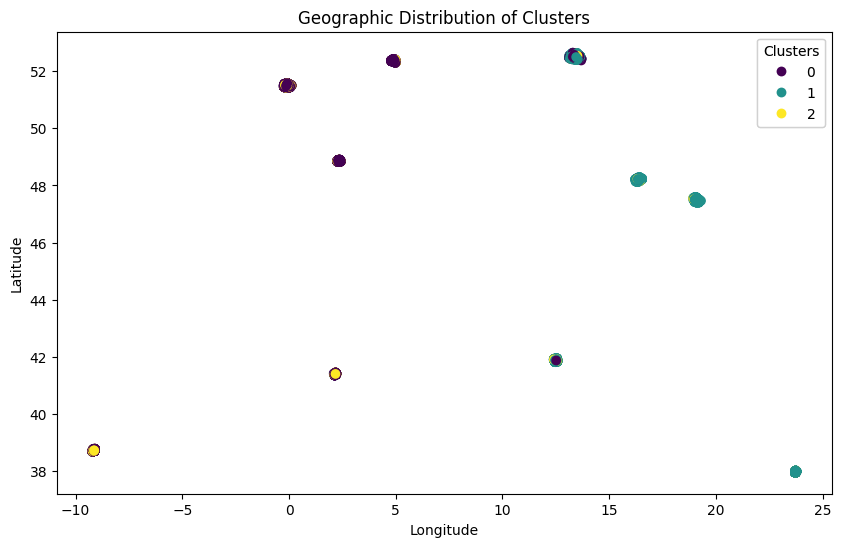

In [18]:
# Attempting to cluster with a chosen number of clusters (4)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the data
df_copy['Cluster'] = clusters

# Visualizing the clusters using a scatter plot (geographic coordinates)
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_copy['lng'], df_copy['lat'], c=df_copy['Cluster'], cmap='viridis', label=df_copy['Cluster'])
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographic Distribution of Clusters')
plt.show()

In [19]:
# Running K-means clustering again with a chosen number of clusters (4)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the data
df_copy['Cluster'] = clusters

# Analyzing the characteristics of each cluster
cluster_characteristics = df_copy.groupby('Cluster').agg({
    'realSum': ['mean', 'std'],
    'person_capacity': ['mean', 'std'],
    'cleanliness_rating': ['mean', 'std'],
    'guest_satisfaction_overall': ['mean', 'std'],
    'lng': ['mean'],
    'lat': ['mean']
}).round(2)

cluster_characteristics

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


realSum         person_capacity       cleanliness_rating        \
           mean     std            mean   std               mean   std   
Cluster                                                                  
0        277.23  117.98            2.75  1.12               9.59  0.54   
1        178.11   76.75            3.47  1.30               9.66  0.52   
2        231.83  116.08            2.92  1.20               7.54  1.38   

        guest_satisfaction_overall           lng    lat  
                              mean    std   mean   mean  
Cluster                                                  
0                            94.31   5.14  -0.04  47.01  
1                            95.19   4.65  16.94  43.27  
2                            75.94  13.76   3.75  46.85

## Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


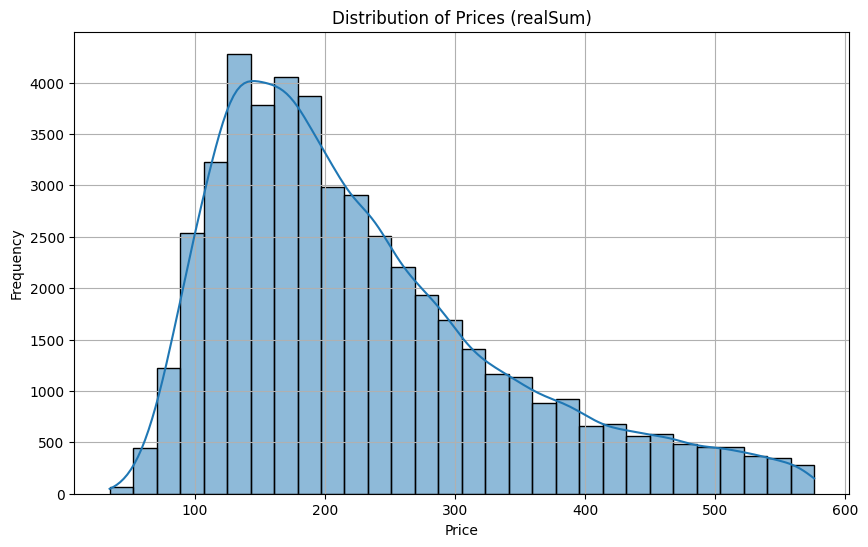

<function matplotlib.pyplot.show(close=None, block=None)>

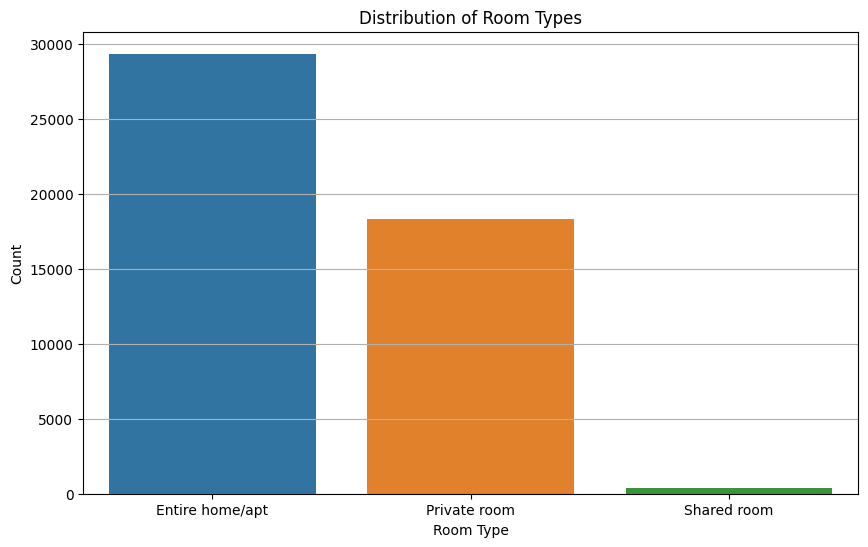

In [20]:
# 1. Summary Statistics for 'realSum'
plt.figure(figsize=(10, 6))
sns.histplot(df['realSum'], bins=30, kde=True)
plt.title('Distribution of Prices (realSum)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Distribution of Room Types
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show

In [21]:
# # Count occurrences of each city
# city_counts = df['city'].value_counts()

# # Plotting
# plt.figure(figsize=(10, 8))
# plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribution of Cities')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()

In [22]:
# sns.pairplot(data=df[["realSum", "room_type", "person_capacity", "bedrooms", "rest_index", "city"]], hue='realSum');

In [23]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
dtype: object

In [24]:
capitals_lat_lng = {
    'Amsterdam': [52.377956, 4.897070],
    'Athens': [37.983810, 23.727539],
    'Barcelona': [41.390205, 2.154007],
    'Berlin': [52.520008, 13.404954],
    'Budapest': [47.497913, 19.040236],
    'Lisbon': [38.736946, -9.142685],
    'London': [51.509865, -0.118092],
    'Paris': [48.864716, 2.349014],
    'Rome': [41.902782, 12.496366],
    'Vienna': [48.210033, 16.363449]
}

map = folium.Map(location=capitals_lat_lng['Budapest'], zoom_start=4.2)

for city, coords in capitals_lat_lng.items():
    folium.Marker(location=coords, popup=city).add_to(map)

map

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


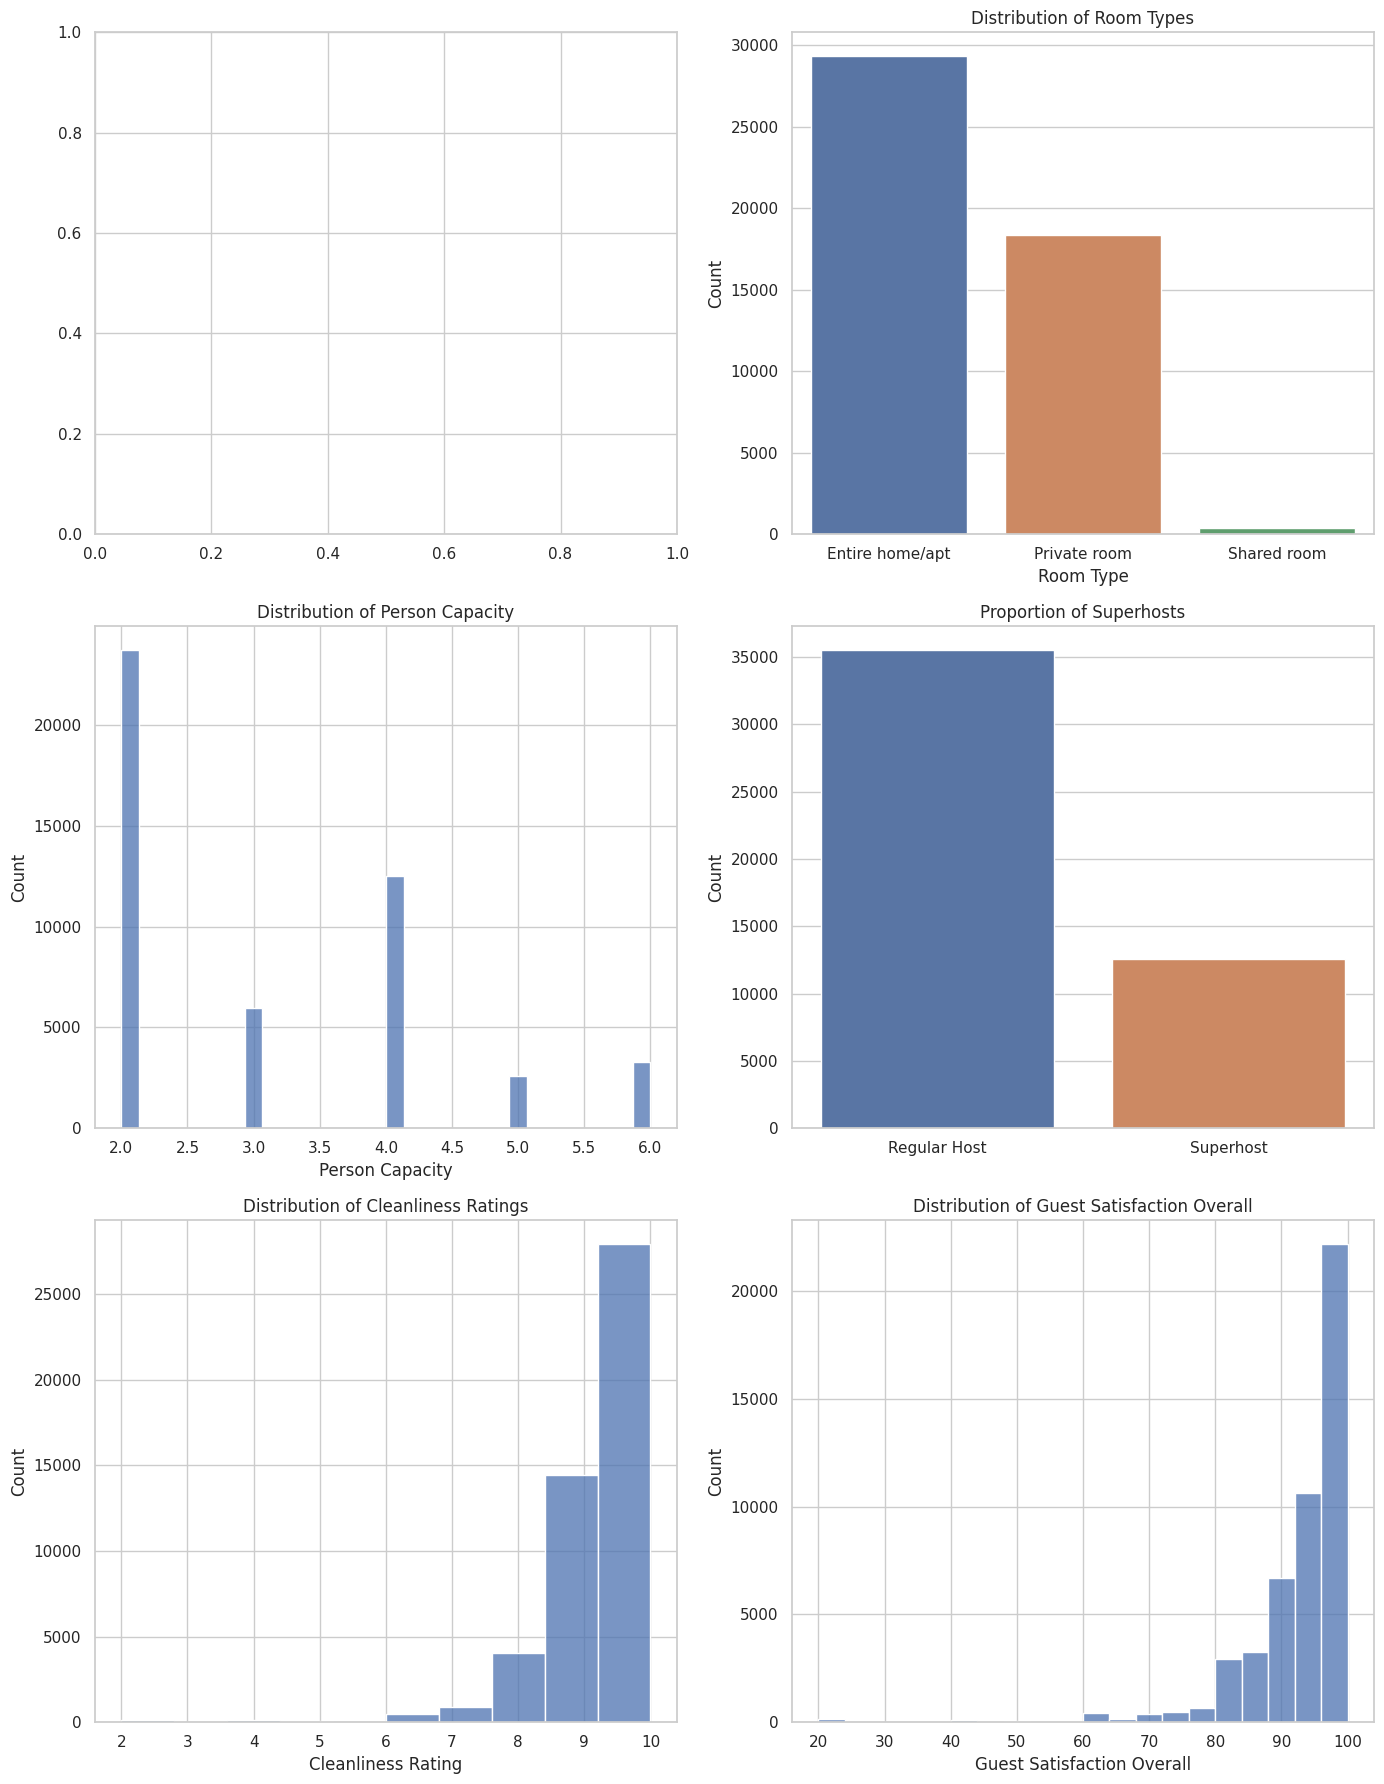

In [25]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Create a figure for multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# # Plotting the number of listings per city
# sns.countplot(data=df, y='city', ax=axes[0, 0], order=data['city'].value_counts().index)
# axes[0, 0].set_title('Number of Listings per City')
# axes[0, 0].set_xlabel('')
# axes[0, 0].set_ylabel('City')

# Plotting the distribution of room types
sns.countplot(data=df, x='room_type', ax=axes[0, 1], order=df['room_type'].value_counts().index)
axes[0, 1].set_title('Distribution of Room Types')
axes[0, 1].set_xlabel('Room Type')
axes[0, 1].set_ylabel('Count')

# Plotting the distribution of person capacity
sns.histplot(data=df, x='person_capacity', bins=30, ax=axes[1, 0], kde=False)
axes[1, 0].set_title('Distribution of Person Capacity')
axes[1, 0].set_xlabel('Person Capacity')
axes[1, 0].set_ylabel('Count')

# Plotting the proportion of superhosts
df['superhost_label'] = df['host_is_superhost'].map({True: 'Superhost', False: 'Regular Host'})
sns.countplot(data=df, x='superhost_label', ax=axes[1, 1])
axes[1, 1].set_title('Proportion of Superhosts')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Count')

# Plotting the distribution of cleanliness ratings
sns.histplot(data=df, x='cleanliness_rating', bins=10, ax=axes[2, 0], kde=False)
axes[2, 0].set_title('Distribution of Cleanliness Ratings')
axes[2, 0].set_xlabel('Cleanliness Rating')
axes[2, 0].set_ylabel('Count')

# Plotting the distribution of guest satisfaction overall
sns.histplot(data=df, x='guest_satisfaction_overall', bins=20, ax=axes[2, 1], kde=False)
axes[2, 1].set_title('Distribution of Guest Satisfaction Overall')
axes[2, 1].set_xlabel('Guest Satisfaction Overall')
axes[2, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Feature Selection/Extraction:

In [26]:
# Encode categorical features
label_encoders = {}
for column in ['room_type', 'city']:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le

for column in ['room_type']:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le

# Convert boolean columns to int (True/False to 1/0)
bool_columns = ['room_shared', 'room_private', 'host_is_superhost']
for column in bool_columns:
    df_copy[column] = df_copy[column].astype(int)

# Show the updated dataframe and check types again
df_copy.head(), df_copy.dtypes

(      realSum  room_type  room_shared  room_private  person_capacity  \
 0  274.875535          0            0             0              5.0   
 1  162.397769          0            0             0              5.0   
 2  289.834747          0            0             0              2.0   
 3  183.148476          1            0             1              2.0   
 4  524.471413          0            0             0              2.0   
 
    host_is_superhost  multi  biz  cleanliness_rating  \
 0                  0      1    0                10.0   
 1                  0      1    0                10.0   
 2                  1      0    1                10.0   
 3                  0      0    0                10.0   
 4                  0      0    1                10.0   
 
    guest_satisfaction_overall  ...  metro_dist  attr_index  attr_index_norm  \
 0                        96.0  ...    0.112154  140.464780        10.059487   
 1                        83.0  ...    0.672109   65.647

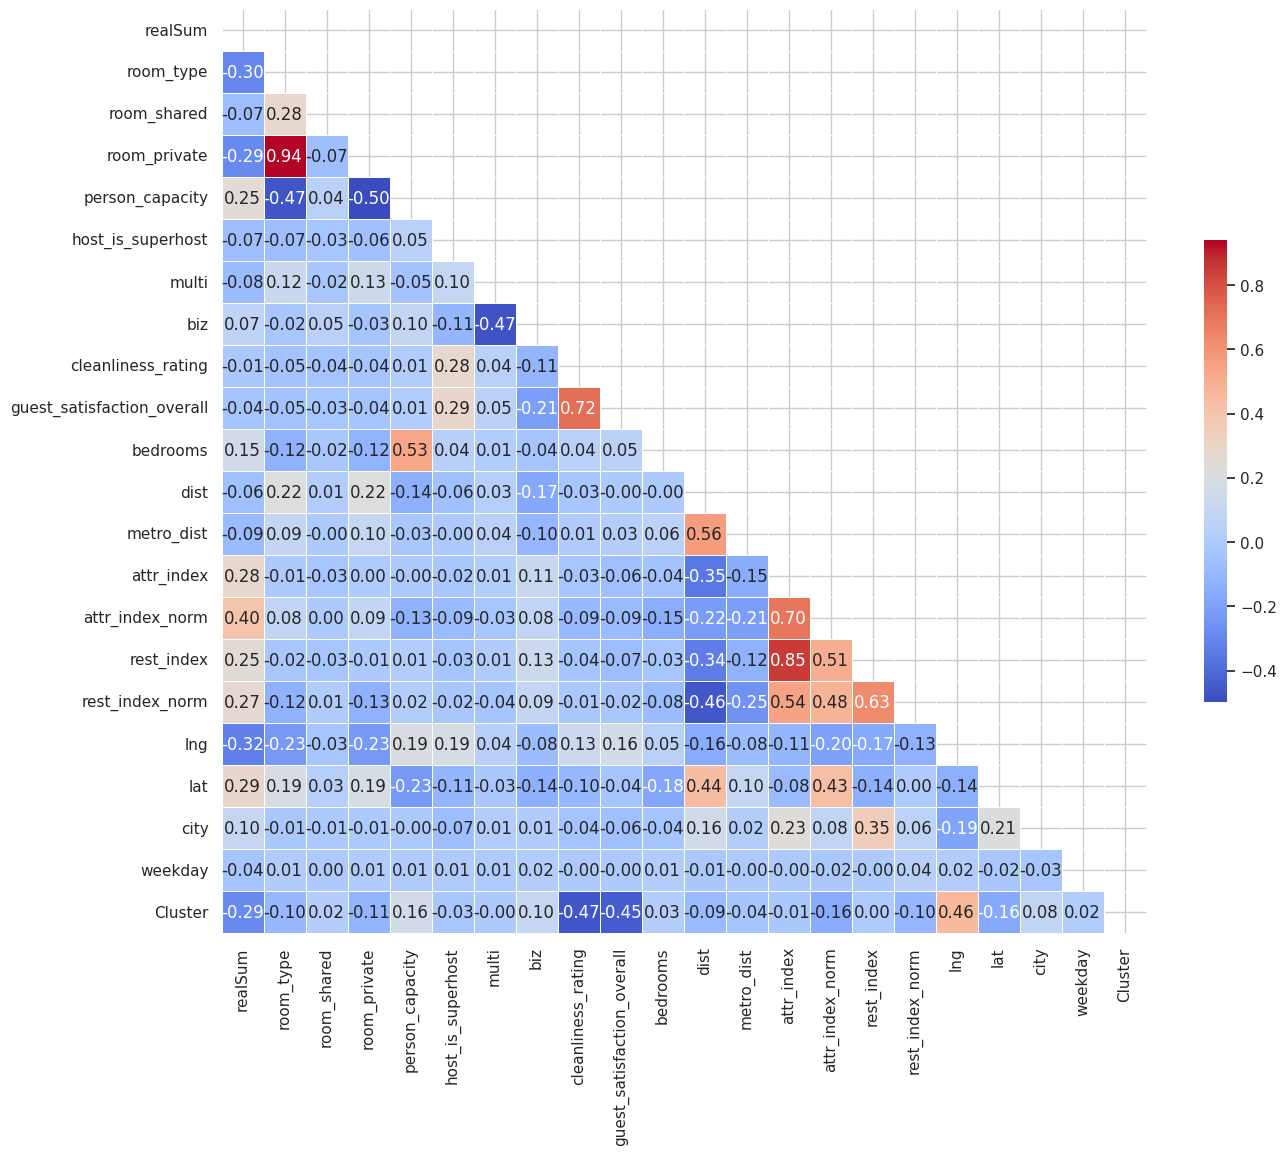

In [27]:
# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show plot
plt.show()

In [28]:
# Calculate the correlation matrix
correlation_matrix = df_copy.corr()

# Filter out columns where the correlation with 'realSum' is between -0.1 and 0.1
low_correlation_columns = correlation_matrix[(correlation_matrix['realSum'] > -0.1) & (correlation_matrix['realSum'] < 0.1)].index

# Print the columns with low correlation
print(low_correlation_columns)

# Remove these columns from the dataset
df_reduced = df.drop(columns=low_correlation_columns)
print(df_reduced.head())

Index(['room_shared', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'dist',
       'metro_dist', 'weekday'],
      dtype='object')
      realSum        room_type  room_private  person_capacity  bedrooms  \
0  274.875535  Entire home/apt         False              5.0         2   
1  162.397769  Entire home/apt         False              5.0         2   
2  289.834747  Entire home/apt         False              2.0         0   
3  183.148476     Private room          True              2.0         0   
4  524.471413  Entire home/apt         False              2.0         0   

   attr_index  attr_index_norm  rest_index  rest_index_norm       lng  \
0  140.464780        10.059487  236.724193         5.659063  16.38100   
1   65.647944         2.475200   96.679149         7.259259  23.73200   
2   87.665125         6.277998  122.565138         2.962352  16.40800   
3  201.131671         9.780042  387.825153        17.891279   2.26703   
4  

In [29]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
city                           object
weekday                          bool
superhost_label                object
dtype: object

# Prepare Training Data

In [30]:
# There is only numeric data left, so we only need to StandardScaler Numeric data
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove the 'realSum' column from the list
numeric_cols.remove('realSum')

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_reduced[numeric_cols])
df_transformed_numeric = pd.DataFrame(scaled_numeric_data, columns=numeric_cols)

# One-hot encoding the categorical data
df_encoded = pd.get_dummies(df_reduced[object_cols])

# Concatenate the scaled numeric data and encoded categorical data
df_transformed = pd.concat([df_transformed_numeric, df_encoded], axis=1)

df_transformed = df_transformed.to_numpy()
df_transformed

array([[1.5266688542741775, 1.5032103552237372, -0.6526904531487564, ...,
        True, True, False],
       [1.5266688542741775, 1.5032103552237372, -0.9917190409773674, ...,
        False, True, False],
       [-0.8593823624724619, -1.8910672392645467, -0.8919493370079151,
        ..., True, False, True],
       ...,
       [nan, nan, nan, ..., False, True, False],
       [nan, nan, nan, ..., False, True, False],
       [nan, nan, nan, ..., False, False, True]], dtype=object)

In [31]:
# Data preparation and column selection
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove 'realSum' column
if 'realSum' in numeric_cols:
    numeric_cols.remove('realSum')

# Create a ColumnTransformer to handle both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), object_cols)
    ])

# Apply the ColumnTransformer
df_transformed = preprocessor.fit_transform(df_reduced)

# Get the names of the one-hot encoded columns
columns_transformed = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
df_transformed = pd.DataFrame(df_transformed, columns=columns_transformed)

# Convert to NumPy array
df_transformed_array = df_transformed.to_numpy()

df_transformed_array

array([[ 1.52666885,  1.50321036, -0.65269045, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.52666885,  1.50321036, -0.99171904, ...,  0.        ,
         1.        ,  0.        ],
       [-0.85938236, -1.89106724, -0.89194934, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.85938236, -0.19392844, -0.81817366, ...,  0.        ,
         1.        ,  0.        ],
       [-0.85938236,  1.50321036, -0.17177215, ...,  0.        ,
         1.        ,  0.        ],
       [-0.85938236, -0.19392844,  0.03146011, ...,  0.        ,
         0.        ,  1.        ]])

In [32]:
y = df_reduced['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed_array, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Linear Regression Model

## Model Define

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [34]:
class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        # Defining a linear layer with n_features input features and 1 output feature
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        # Forward pass through the linear layer
        return self.linear(x)

In [35]:
model = LinearRegression(X_train.shape[1]).to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=23, out_features=1, bias=True)
)


In [36]:
loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01) 

In [37]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [38]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = LinearRegression(n_features=X_train.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01) 
        early_stopping = EarlyStopping(patience=10, verbose=True)
        

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, target)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += loss_function(output, target).item()
            val_loss /= len(val_loader)

            if epoch % 100 == 0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'LinearRegression_best_model.pth')  # Save model to disk
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [39]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=100000, batch_size=64, lr=0.01, epsilon=0.0001)

Starting fold 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, t

Fold 1, Epoch 1, Validation MAE Loss: 56715.99803073347
Early stopping triggered
Early stopping triggered at epoch 46
Starting fold 2


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold 2, Epoch 1, Validation MAE Loss: 57259.41448217975
Early stopping triggered
Early stopping triggered at epoch 45
Starting fold 3
Fold 3, Epoch 1, Validation MAE Loss: 57130.25778021694
Early stopping triggered
Early stopping triggered at epoch 62
Starting fold 4
Fold 4, Epoch 1, Validation MAE Loss: 57066.884232954544
Early stopping triggered
Early stopping triggered at epoch 44
Starting fold 5
Fold 5, Epoch 1, Validation MAE Loss: 55929.89582257231
Early stopping triggered
Early stopping triggered at epoch 29
Average Validation Loss: 12471.962449154184


12471.962449154184

In [40]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LinearRegression(n_features=input_features).to(device)
    model.load_state_dict(torch.load('/kaggle/working/LinearRegression_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [41]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 12638.399080996482


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [42]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 12478.0712890625, RMSE: 111.70528411865234, MAE: 89.02227783203125, R²: 0.017251927484286833


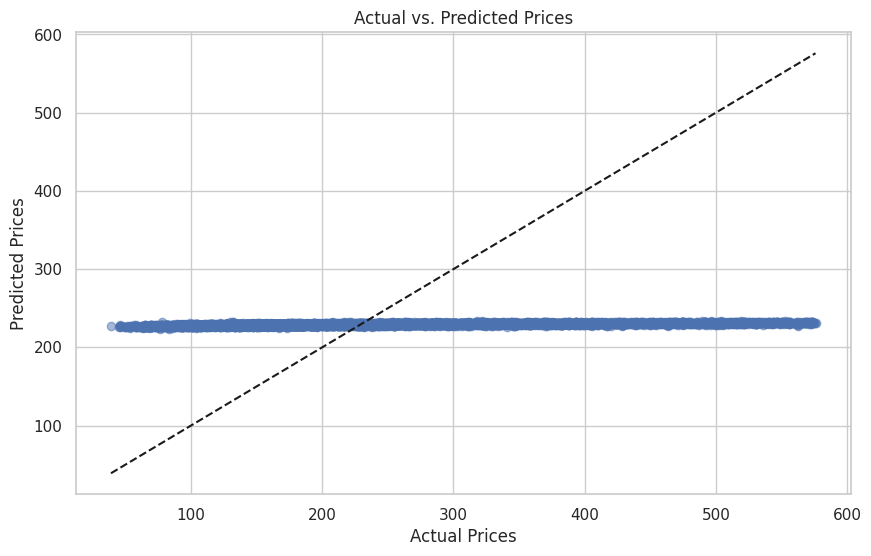

In [43]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# Random Forest Model

## Model Define

In [44]:
from sklearn.ensemble import RandomForestRegressor

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        """Initialize the random forest model."""
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    def fit(self, X, y):
        """Fit the model to the data."""
        self.model.fit(X, y)

    def predict(self, X):
        """Make predictions using the trained model."""
        return self.model.predict(X)

In [45]:
model = RandomForest(n_estimators=100, max_depth=None, random_state=42)
print(model)

In [46]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import joblib

def cross_validate_model(X, y, n_splits=5):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_losses = []
    best_model = None
    lowest_val_loss = np.inf

    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        val_loss = mean_squared_error(y_val, y_pred)
        val_losses.append(val_loss)
        
        # Update the best model if current model is better
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_model = model
        
        print(f'Validation MSE: {val_loss}')

    avg_val_loss = np.mean(val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    
    # Save the best model
    joblib.dump(best_model, 'RandomForest_best_model.pkl')
    
    return avg_val_loss

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed_array, y, test_size=0.2, random_state=42)

avg_loss = cross_validate_model(X_train_val, y_train_val)

Validation MSE: 3446.0247460355945
Validation MSE: 3134.2152791567614
Validation MSE: 3365.6850044175826
Validation MSE: 3362.188478786695
Validation MSE: 3457.3821507289795
Average Validation Loss: 3353.0991318251226


In [48]:
# Load the best model for further testing
best_model = joblib.load('/kaggle/working/RandomForest_best_model.pkl')

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_test_pred)

r2 = r2_score(y_test, y_test_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 3307.986746757579
RMSE: 57.51510016297963
MAE: 39.793440617591
R²: 0.7394695318947204


# SVR Model

## Model Define

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [51]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [52]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [53]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=23, out_features=1, bias=True)
)


In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [55]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [56]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SVR(n_features=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            if epoch % 500 == 0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'SVR_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [57]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=100000, batch_size=64, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 217.95869647569893
Fold 1, Epoch 501, Validation MAE Loss: 58.465195710993996
Early stopping triggered
Early stopping triggered at epoch 871
Starting fold 2
Fold 2, Epoch 1, Validation MAE Loss: 219.69702665470848
Fold 2, Epoch 501, Validation MAE Loss: 59.1821564603443
Early stopping triggered
Early stopping triggered at epoch 751
Starting fold 3
Fold 3, Epoch 1, Validation MAE Loss: 218.99792896617544
Fold 3, Epoch 501, Validation MAE Loss: 58.53342721481954
Early stopping triggered
Early stopping triggered at epoch 716
Starting fold 4
Fold 4, Epoch 1, Validation MAE Loss: 218.90864890863088
Fold 4, Epoch 501, Validation MAE Loss: 58.69473060103488
Early stopping triggered
Early stopping triggered at epoch 715
Starting fold 5
Fold 5, Epoch 1, Validation MAE Loss: 216.41372567168938
Fold 5, Epoch 501, Validation MAE Loss: 57.83176322810906
Early stopping triggered
Early stopping triggered at epoch 746
Average Validation Loss: 58.47

58.47594089350425

In [58]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=300,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Results

In [59]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SVR(n_features=input_features).to(device)
    model.load_state_dict(torch.load('SVR_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [60]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += epsilon_insensitive_loss(output, target, 0.1).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 57.86398143641996


In [61]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 6714.30419921875, RMSE: 81.94085693359375, MAE: 58.01900100708008, R²: 0.47119475148698153


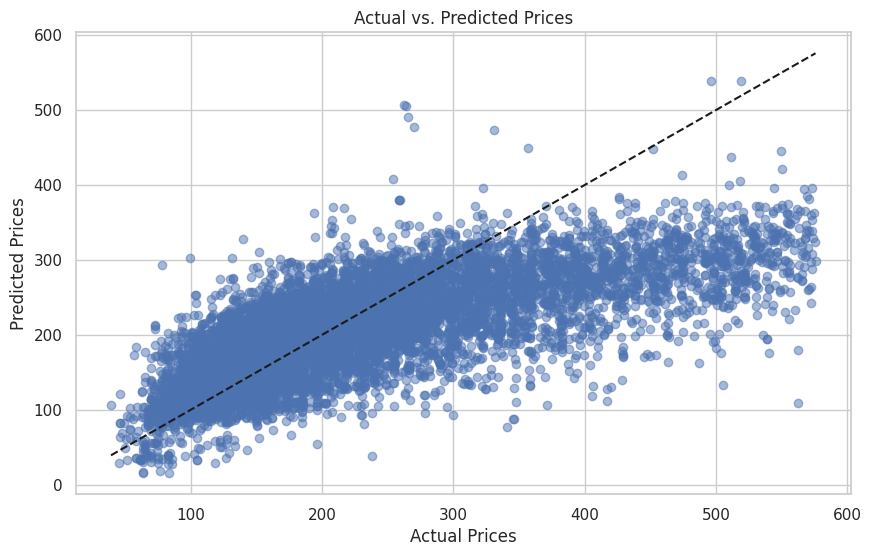

In [62]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# *MLP* Model

## Model Define

In [63]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output(x)
        return x

In [64]:
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(256, 128)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(128, 64)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(64, 32) 
#         self.relu4 = nn.ReLU()
#         self.output = nn.Linear(32, 1)
#         self.dropout = nn.Dropout(0.5) 

#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.dropout(x) 
#         x = self.relu2(self.fc2(x))
#         x = self.dropout(x)
#         x = self.relu3(self.fc3(x))
#         x = self.dropout(x)
#         x = self.relu4(self.fc4(x))
#         x = self.output(x)
#         return x

In [65]:
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [66]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.01):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MLP(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)
            
            if epoch % 100 ==0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')
            
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'MLP_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [67]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=10000, batch_size=128, lr=0.001, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 228.34437611063973
Early stopping triggered
Early stopping triggered at epoch 98
Starting fold 2
Fold 2, Epoch 1, Validation MAE Loss: 229.6180552498239
Early stopping triggered
Early stopping triggered at epoch 56
Starting fold 3
Fold 3, Epoch 1, Validation MAE Loss: 229.38891526519276
Early stopping triggered
Early stopping triggered at epoch 55
Starting fold 4
Fold 4, Epoch 1, Validation MAE Loss: 229.45651445232454
Early stopping triggered
Early stopping triggered at epoch 76
Starting fold 5
Fold 5, Epoch 1, Validation MAE Loss: 226.63834043409003
Early stopping triggered
Early stopping triggered at epoch 71
Average Validation Loss: 48.33729581989226


48.33729581989226

In [68]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=100000,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Result

In [69]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=X_train.shape[1]).to(device)
    model.load_state_dict(torch.load('MLP_best_model.pth', map_location=device))
    return model, device

In [70]:
best_model, device = load_best_model(df_transformed.shape[1])

In [71]:
evaluate_model(best_model, test_loader, device)

Test Loss: 47.464708947188015


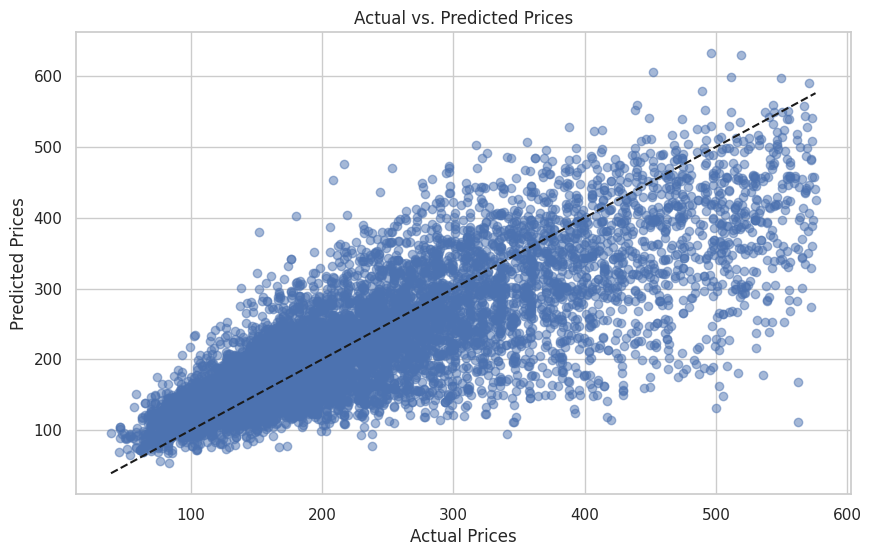

In [72]:
plot_predictions(best_model, test_loader, device)